# Kantorovich distance as similiarity between documents

In [68]:
from matplotlib import cm
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.spatial as spatial
%matplotlib inline

document_1 = ["media", "Illinois", "speaks", "Obama"]
document_2 = ["President", "greets", "press", "Chicago"]

### Load word embedding dictionary

In [63]:
word_embedding = np.load("word_embedding.npy").item()

def distance(word1, word2):
    return np.linalg.norm(word_embedding[word1] - word_embedding[word2])

# TODO: Construct C matrix where C_ij = dist(document_1[i], document_2[j]).
C = [[distance(document_1[w_1],document_2[w_2]) for w_2 in range(len(document_2))] for w_1 in range(len(document_1))]
print(C)

[[3.270594, 4.215941, 2.1343176, 3.5777214], [3.755565, 4.7424903, 3.8530126, 2.565475], [3.7756965, 3.4098573, 3.376263, 4.0446653], [3.3538146, 4.7079706, 3.6897867, 3.7211564]]


### Compute the transportation plan as well as the transportation cost (aka EMD)

In [64]:
# We assume that the length of document one and two are equal.
l = len(document_1)

# Compute normalized frequency vectors for sentence one and two. 
mu = [1. / l for _ in range(l)]
nu = [1. / l for _ in range(l)]

# To formulate and solve the LP, the C and P matrices need to reshaped
# to vectors of length lxl
c = np.array(C).reshape((l**2))

# Construct matrices of ones, A_r and A_t, which when multiplied by P 
# reshaped to lxl vector gives us the equality contraints.
# Where row i of A_r equals sum of entries of P_i and row i of A_t
# equals sum of entries of row i of (P^T). 
#A_r = np.zeros((l, l, l))
#A_t = np.zeros((l, l, l))
flatten = lambda l: [item for sublist in l for item in sublist]
A_top_1 = np.array(flatten([[1]*l, [0]*l*(l-1)]))
A_top = np.array([np.roll(A_top_1, n*l) for n in range(l)])
A_bot_1_bit = flatten([[1], [0]*(l-1)])
A_bot = np.array([np.tile(np.roll(A_bot_1_bit, n), l) for n in range(l)])
A = np.vstack((A_top, A_bot))
print(A)
b = np.hstack((mu,nu))
print(b)

# TODO: Solve LP with objective C^Tx, constraints Ax = b.
x = opt.linprog(c, A_eq=A, b_eq=b)
P = np.reshape(x.x, (l,l))
emd = x.fun

print("EMD: " + str(emd))
print(x.x)

[[1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0]
 [0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0]
 [0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0]
 [0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1]]
[0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25]
EMD: 2.8658661246299744
[0.   0.   0.25 0.   0.   0.   0.   0.25 0.   0.25 0.   0.   0.25 0.
 0.   0.  ]


Visualize P transportation plan: 


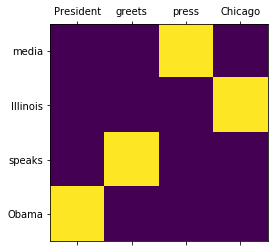

In [65]:
print("Visualize P transportation plan: ")

fig = plt.figure()
ax = fig.add_subplot(111)
ax.matshow(P)

# We want to show all ticks
ax.set_xticks(np.arange(len(document_1)))
ax.set_yticks(np.arange(len(document_2)))

ax.set_xticklabels(document_2)
ax.set_yticklabels(document_1)
plt.savefig('kantorovich_plan.png', dpi=300)
plt.show()

In [73]:
document_1_word_vec = [1, 1, 1, 1, 0, 0, 0, 0]
document_2_word_vec = [0, 0, 0, 0, 1, 1, 1, 1]
np.dot(document_1_word_vec, document_2_word_vec) / (np.linalg.norm(document_1_word_vec) * np.linalg.norm(document_2_word_vec))

0.0